<a href="https://colab.research.google.com/github/nemoware/analyser/blob/structure-detector/notebooks/TF_structure_keras_uber_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

import tensorflow as tf
print(tf.__version__)

_git_branch = 'structure-detector'

TensorFlow 1.x selected.
1.15.2


#### Mount drive

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Import code from gitHub + tools

In [0]:
!pip install overrides pyjarowinkler 
!rm -r nlp_tools
!git clone --single-branch --branch $_git_branch https://github.com/nemoware/analyser.git nlp_tools
 

import sys
sys.path.insert(0, '/content/nlp_tools')


  Created wheel for overrides: filename=overrides-2.8.0-cp36-none-any.whl size=5609 sha256=461a99bc00bfd8a75d675b4024ac626012f7a51630014e66cc1f7c019d35ebac
  Stored in directory: /root/.cache/pip/wheels/df/f1/ba/eaf6cd7d284d2f257dc71436ce72d25fd3be5a5813a37794ab
Successfully built overrides
rm: cannot remove 'nlp_tools': No such file or directory
Cloning into 'nlp_tools'...
remote: Enumerating objects: 240, done.
remote: Counting objects: 100% (240/240), done.
remote: Compressing objects: 100% (183/183), done.
remote: Total 5973 (delta 130), reused 140 (delta 57), pack-reused 5733
Receiving objects: 100% (5973/5973), 245.05 MiB | 26.02 MiB/s, done.
Resolving deltas: 100% (4254/4254), done.


In [0]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

def plot_emb(matrix, title=None):    
  mt = matrix.T  
  with sns.axes_style("white"):
    plt.figure(figsize=(25, 6))
    ax = sns.heatmap(mt, square=False,  cmap="RdYlBu", center=0)
    if title:
      plt.title(title)
    plt.show()

def load_doc(index_in_trainset:int):
  _fn = dataset_manager.trainset_rows.iloc[index_in_trainset]['pickle']
  with open(_fn, "rb") as pickle_in:
    _doc: LegalDocument = pickle.load(pickle_in)
    return _doc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Prepare trainset


#### Read meta

In [0]:

import pandas as pd
from os import path
from colab_support.renderer import *
from trainsets.trainset_tools import TrainsetBalancer, SubjectTrainsetManager

TRAINSETS_PATH='/content/drive/My Drive/GazpromOil/trainsets'
VERSION_PATH='1_1_19'
TRAINSET_META_FN='contracts.subjects-manually-filtered.csv'

csv_path = path.join(TRAINSETS_PATH, 'meta_info', TRAINSET_META_FN)

# random
dataset_manager = SubjectTrainsetManager(csv_path)
dataset_manager.trainset_rows

### prepare semantic_labels

0.88 Газпром нефть Газпромнефть Шиппинг
0.93 Газпром нефть Газпромнефть-Аэро
0.94 Газпром нефть Газпромнефть-СМ
0.96 Газпромнефть-Аэро Газпромнефть-Энерго
0.97 Газпромнефть-СМ Газпромнефть-ЗС
0.98 Газпромнефть-МНПЗ Газпромнефть-ОНПЗ
HyperParameters.subsidiary_name_match_min_jaro_similarity 0.98


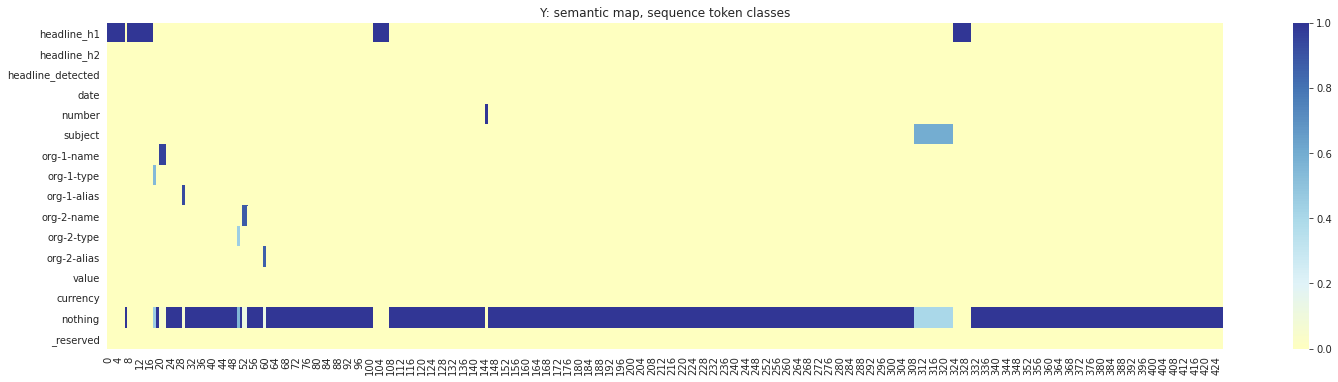

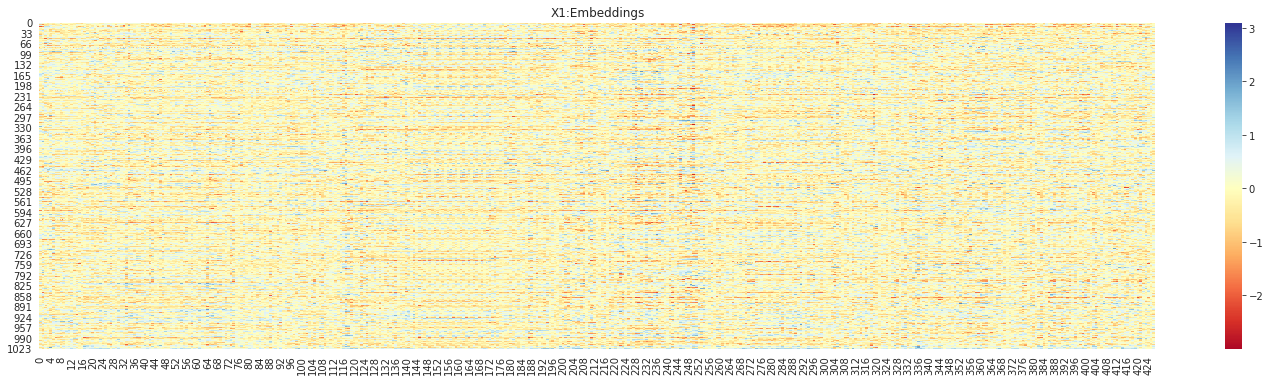

In [0]:
import pickle
import numpy as np
from analyser.legal_docs import LegalDocument, make_headline_attention_vector
from analyser.headers_detector import make_predicted_headline_attention_vector


seq_labels_contract = [
                'headline_h1','headline_h2','headline_detected',
                'date', 'number', 'subject', 
                'org-1-name', 'org-1-type',  'org-1-alias',
                'org-2-name', 'org-2-type',  'org-2-alias', 
                'value', 'currency', 'nothing', '_reserved'
                ]

 
def get_semantic_labels(_doc) -> pd.DataFrame:
  
  semantic_map = _doc.get_semantic_map()
  for sl in seq_labels_contract:
    if sl not in semantic_map:
      semantic_map[sl] = np.zeros( len(_doc) )
 

  semantic_map['headline_h1'] = make_headline_attention_vector(_doc) ##adding headers
  
  semantic_map = semantic_map[seq_labels_contract]
  semantic_map['nothing'] = 1.0 # to balance NN
  
  for sl in seq_labels_contract:
    if sl !='nothing':
      semantic_map['nothing'] *=  (1. - semantic_map[sl])

  semantic_map.clip(0,1)
  return semantic_map

d = load_doc(55)
_sm = get_semantic_labels(d)
_sm
plot_emb(_sm, title="Y: semantic map, sequence token classes")
plot_emb(d.embeddings, title="X1:Embeddings")
 

In [0]:
HTML(render_doc (d, _sm))

### Token features

In [0]:
def _has_symbols(txt:str, strange_symbols) -> int:
  for c in strange_symbols:
    if txt.count(c) >0:
      return 1.
  return 0.

def _onehot(x: bool or int) -> float:
  if x:
    return 1.0
  else:
    return 0.0

def get_token_features(token:str):
  features={ 
    'isdigit': _onehot(token.isdigit()),
    'istitle': _onehot(token.istitle()),
    'nl':        _onehot(token=='\n' or token=='\r'),    
             
    
    
    'has_underscore': _has_symbols(token, '_'),

    'isupper': _onehot(token.isupper()),
    'has_quotes': _has_symbols(token, '«»"\'"'),
    'has_trash': _has_symbols(token, '[]$@+^&(){}<>'),
    'has_syntax': _has_symbols(token, '!.:;,'),

    'isalpha': _onehot(token.isalpha()),
    'len_lt3': _onehot(len(token)<3),    
    'len_lt2': _onehot(len(token)<2),    
    'islower': _onehot(token.islower()),
    'isprintable': _onehot(token.isprintable()),
   
  }
  return features

def get_tokens_features(tokens):
  doc_features = []
  for t in tokens:
    _features = get_token_features(t )
    doc_features.append(_features)

  doc_featuresX_data = pd.DataFrame.from_records(doc_features)
  doc_featuresX_data['_reserved'] = 0.0
  return doc_featuresX_data



token_features = get_tokens_features(d.tokens)
token_features['h'] =  make_predicted_headline_attention_vector(d, False)  
# token_features['sum'] = token_features.values.sum(axis=-1)
#render all
plot_emb(token_features, title='Tokens features')
display(HTML(render_doc (d, token_features)))
token_features.head()



Balance trainset 
TODO: consider https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

## Batch generator & TODOs 🙏

- [x] TODO: ~~try different embedding padding~~ --> not better =(
- [x] TODO: ~~the amount of noise in embedding may depend on popularity of class subject)~~ -->.. hm.. seems like it works
- [x] TODO: try `padded_batch` --> done. 
- [ ] TODO: select min or mean emb length in batch to pad batches
- [ ] TODO: add outliers to the trainset
- [ ] TODO: use sparse_categorical_entropy instead of one-hot encodings

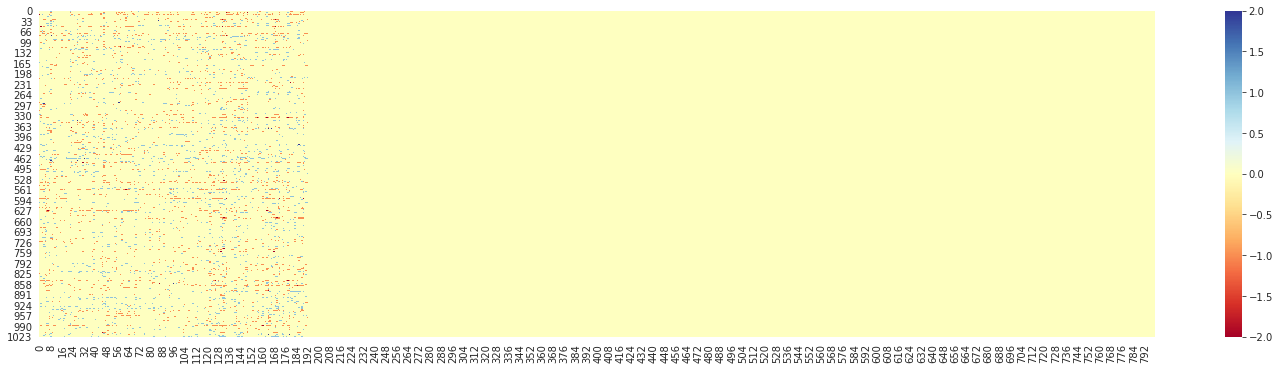

In [0]:
# ---- debug ---
_t_generator = dataset_manager.get_generator(batch_size=1, all_indices=[0], randomize=True)
_t_x, _t_y =  next(_t_generator)
del _t_generator

plot_emb(_t_x[0])

## Generators

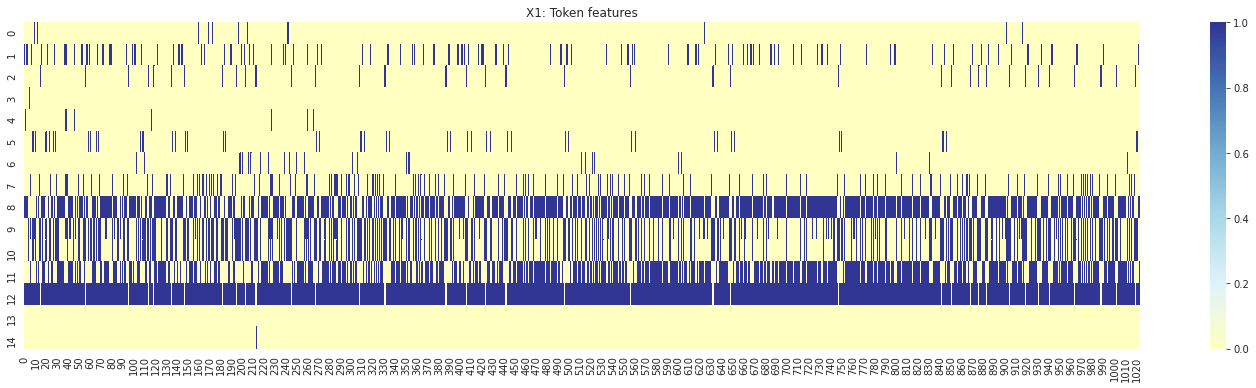

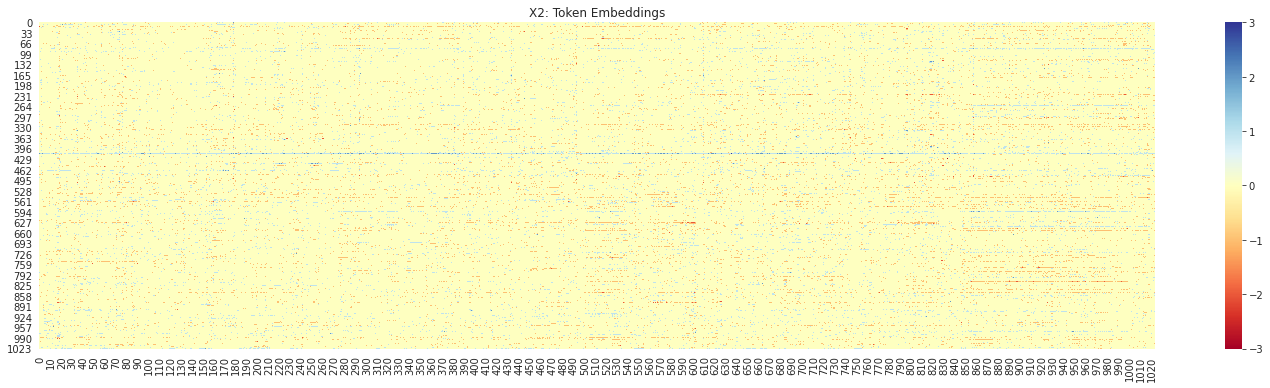

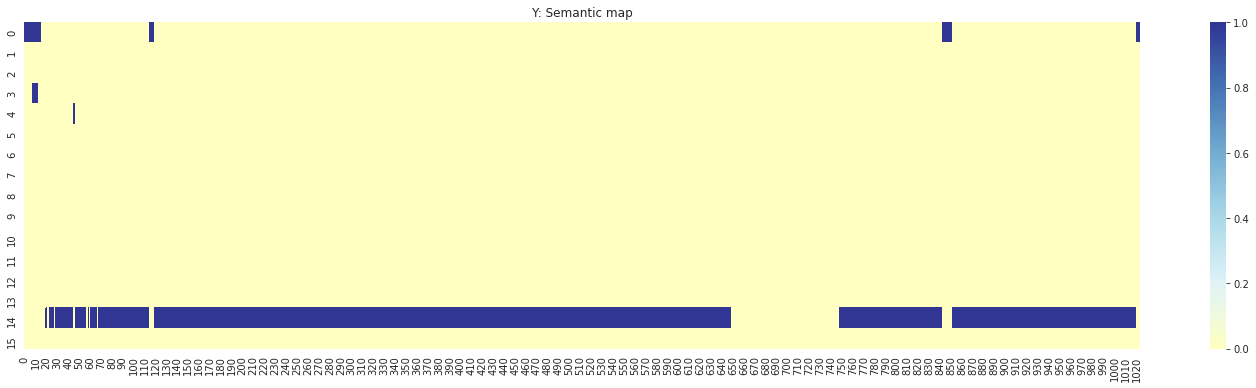

In [29]:
import random

EPOCHS = 20
BATCH_SIZE = 48
EMB =  1024



from keras.preprocessing.sequence import pad_sequences

#TODO: add padding outside cache
_CACHE = {}
 

def pad_things(xx, maxlen, padding='post'):
  for x in xx:
    yield pad_sequences( [x], maxlen=maxlen, padding=padding, truncating=padding) [0]

def make_xy(i):
   
  d = load_doc(i)

  label = get_semantic_labels(d)
  label = np.clip(label, 0, 1)

  token_features = get_tokens_features(d.tokens)
  token_features['h'] =  make_predicted_headline_attention_vector(d, False)  
 
  return (d.embeddings, token_features.values), label

def make_generator(self, indices, batch_size=BATCH_SIZE):

  while True:
    maxlen = 128 * random.choice([1, 2, 3, 4, 5, 6, 7, 8, 9])
    
    # Select files (paths/indices) for the batch
    batch_indices = np.random.choice(a=indices, size=batch_size)

    batch_input_e = []
    batch_input_h = []
    batch_output = []

    # Read in each input, perform preprocessing and get labels
    for i in batch_indices:
      if i in _CACHE:        
        x, y  = _CACHE[i] 
      else:        
        x, y = make_xy(i)         
        _CACHE[i] = (x, y)        
       

      padded = list(  pad_things( [x[0], x[1], y], maxlen ) )
      batch_input_h.append( padded[1])
      batch_input_e.append( padded[0] )
      batch_output.append(padded[2])


    batch_y = np.array(batch_output)
    batch_x_h = np.array(batch_input_h)
    batch_x_e = np.array(batch_input_e)

    
  
    # Return a tuple of (input, output) to feed the network
    yield [[batch_x_e, batch_x_h], batch_y]
  

 
_gen  = make_generator(dataset_manager, dataset_manager.train_indices, 2)
x, y = next(_gen)
# x, y = make_xy(55)
# del _gen


plot_emb(x[1][0], 'X1: Token features')
plot_emb(x[0][0], 'X2: Token Embeddings')
plot_emb(y[0], 'Y: Semantic map')

In [0]:
TOKEN_FEATURES = 2 + len(get_token_features("a"))
print(TOKEN_FEATURES)

15


# Build Models

### common

In [0]:
%tensorflow_version 1.x
import tensorflow as tf
print('tensorflow', tf.__version__)

from keras.utils.vis_utils import model_to_dot
from sklearn.metrics import classification_report
from IPython.display import SVG
from keras.models import load_model


from tensorflow import keras
from keras.layers import Conv1D, LSTM, GRU, BatchNormalization, TimeDistributed, Dense, Bidirectional, Input, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.models import Sequential, Model
from keras.layers import concatenate, SpatialDropout1D
from keras.layers import MaxPooling1D, Activation, ThresholdedReLU, GaussianNoise
from keras.utils import plot_model


tensorflow 1.15.2


In [0]:
HISTORIES={}

callbacks

In [0]:

from os import mkdir

model_checkpoint_path = path.join(TRAINSETS_PATH, 'checkpoints', VERSION_PATH)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, min_lr=1E-6, verbose=1)

print('model_checkpoint_path', model_checkpoint_path)
 

model_checkpoint_path /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19


In [0]:

def plot_training_history(history):
  # Plot training & validation accuracy values
  for m in history.params['metrics']:
    plt.plot(history.history[m])     
    plt.title(m)
    plt.xlabel('Epoch')
    plt.legend( history.params['metrics'], loc='upper left')
  plt.show()
  

def plot_compare_models():
  plt.figure(figsize=(10,5))
  for key in HISTORIES:
    history = HISTORIES[key]

    # plt.plot(history.history['loss'], label=f'{key} loss')
    plt.plot(history.history['val_loss'], label=f'{key}')
  
  plt.title('Compare models val_loss')   
  plt.legend(loc='upper left')
  plt.show()


def get_stats_df():
  stats_path = path.join(model_checkpoint_path, 'train_statistics0.csv')
  
  try: 
    stats = pd.read_csv(stats_path, index_col='model_name')  
  except: 
    print(f'🦖🦖🦖cannot read {stats_path}')
    stats = pd.DataFrame(columns = ['model_name', 'epoch','val_acc', 'val_loss', 'loss', 'acc' ] ).set_index('model_name')

    
  
  stats.to_csv(stats_path )
  return stats, stats_path


def save_stats(model_name):
  h = HISTORIES[model_name]
  stats, stats_path = get_stats_df()

  for m in h.params['metrics']:
    if m not in stats:
      stats[m]=float('nan')
  for m in h.params['metrics']:
    stats.at[model_name, m] = h.history[m][-1]
  
  stats.at[model_name, 'epoch'] = h.epoch[-1]
  
  stats.to_csv(stats_path)
  stats.to_csv('stats.csv')
  return stats

# save_stats('conv_bi_LSTM_dropouts_')
__stats, _ = get_stats_df()
__stats

,epoch,val_acc,val_loss,loss,acc,accuracy,categorical_accuracy,val_accuracy,val_categorical_accuracy
model_name,,,,,,,,,
conv_bi_LSTM_dropouts_binary,0.0,NaN,0.004962,0.003217,NaN,0.998953,0.966667,0.998860,0.963235
conv_bi_LSTM_dropouts_,0.0,NaN,0.289789,0.124076,NaN,0.960833,0.960833,0.942402,0.942402
structure_detection_model_01,1.0,NaN,0.022820,0.016124,NaN,0.998145,0.998145,0.998235,0.998235
structure_detection_model_03,29.0,NaN,0.046486,0.006822,NaN,0.760092,0.760092,0.519234,0.519234
structure_detection_model_02,9.0,NaN,0.163646,0.100815,NaN,0.816302,0.816302,0.598079,0.598079


#### Confusion matrix

In [0]:
from analyser.structures import ContractSubject
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_curve, auc, roc_auc_score

def onehots2labels(preds):
    _x = np.argmax(preds, axis=-1)
    return [ ContractSubject(k).name for k in _x ]


In [0]:
validation_steps = int(len(dataset_manager.test_indices)/BATCH_SIZE)
steps_per_epoch = int(len(dataset_manager.train_indices)/BATCH_SIZE/2)

print('validation_steps=', validation_steps)
print('steps_per_epoch=', steps_per_epoch)


train_generator=None
test_generator=None
def train_and_evaluate_model(model, generator=train_generator, test_generator=test_generator):
  
  print(f'model.name={model.name}')
  dataset_manager.print_parameters()

  _logger1 = CSVLogger( path.join(model_checkpoint_path, model.name+'.log.csv'), separator=',', append=True)
  _logger2 = CSVLogger(  model.name+'.log.csv', separator=',', append=True)


  checkpoint = ModelCheckpoint( path.join(model_checkpoint_path, model.name), 
                               monitor='val_loss', mode='min', save_best_only=True,
                               verbose=1) 
  
  checkpoint_weights = ModelCheckpoint( path.join(model_checkpoint_path, model.name+".weights"), 
                               monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True,
                               verbose=1) 
  
  history = model.fit_generator(
      generator=generator, 
      epochs=EPOCHS,  
      callbacks=[reduce_lr, checkpoint, checkpoint_weights], #, _logger1, _logger2
      steps_per_epoch=steps_per_epoch,
      validation_data=test_generator, 
      validation_steps=validation_steps )
  
  HISTORIES[model.name]=history
  save_stats(model.name)
  plot_training_history(history)
  plot_compare_models()



validation_steps= 17
steps_per_epoch= 25


In [0]:
raise('stop!!')

TypeError: ignored

## Models 🦖

### 152K structure_detection_model_02 BAD :(
 

Model: "structure_detection_model_02"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     (None, None, 1024)   0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
gaussian_noise_3 (GaussianNoise (None, None, 1024)   0           drops[0][0]                      
__________________________________________________________________________________________________
input_headlines_att (InputLayer (None, None, 15)     0                                            
_______________________________________________________________________

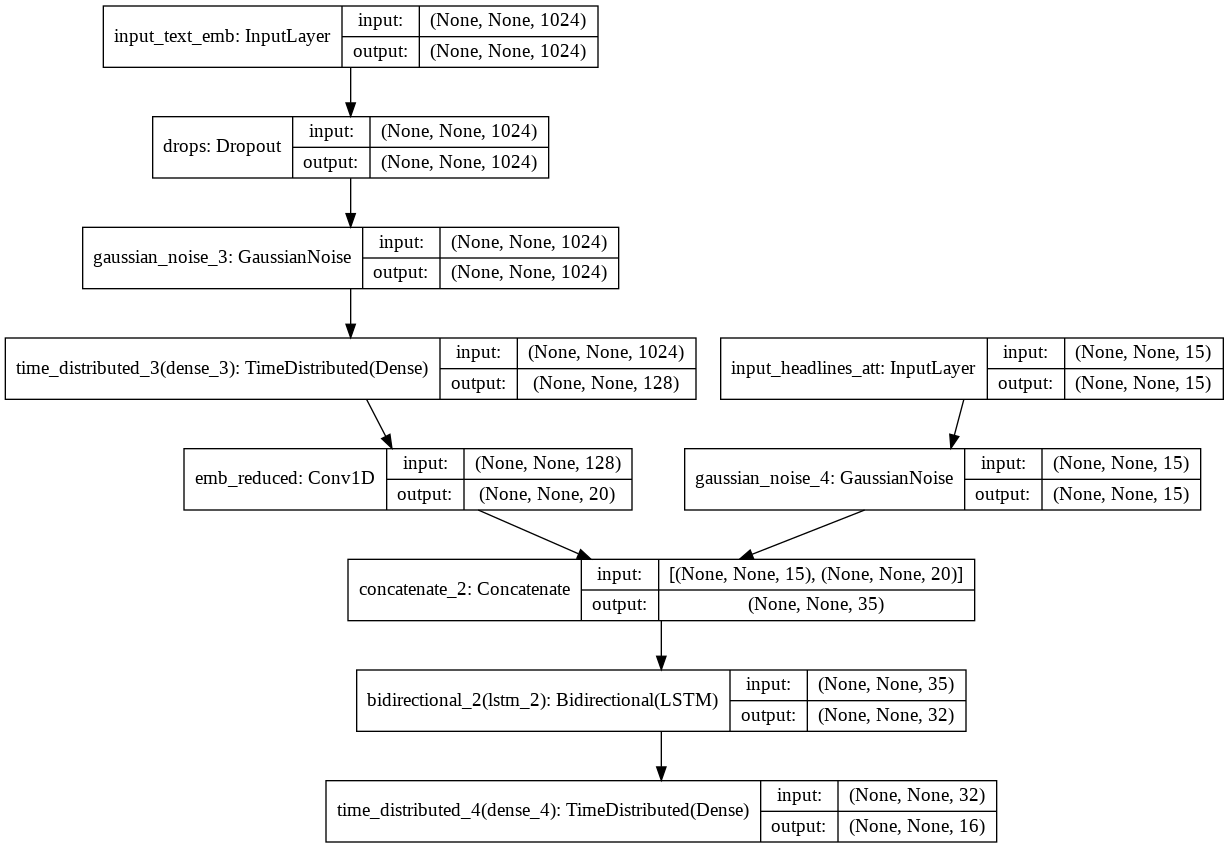

In [0]:
def structure_detection_model_02 (name): 

  EMB =   1024
  FEATURES = len(seq_labels_contract)

  input_text_emb =  Input(shape = [ None, EMB] , dtype='float32', name="input_text_emb")
  input_headlines = Input(shape=  [ None, TOKEN_FEATURES],    dtype='float32', name="input_headlines_att")
  

 
  if True: # 1: input: embeddings
    # reducing embedding dimetionality
    _out = Dropout(0.5, name="drops")(input_text_emb) #small_drops_of_poison
    _out = GaussianNoise(0.01)(_out)  
    _out = TimeDistributed(Dense(128, activation="sigmoid"))(_out)
    _out = Conv1D( filters = 20, kernel_size=(6), padding='same', activation='relu', name="emb_reduced" )(_out)
  # --------

  if True: # 2: input: random-forest-predicted headlines met info
    _i2 = GaussianNoise(0.1)(input_headlines)   


  _out = concatenate( [_i2, _out], axis=-1 ) # mixing in the random-forest-predicted headlines
  _out = Bidirectional(LSTM(16, return_sequences=True))(_out)  
  _out = TimeDistributed(Dense(FEATURES, activation="relu"))(_out)
 
  
  model = Model(inputs=[input_text_emb, input_headlines], outputs=_out, name=name)
 
  model.compile(loss='mse', optimizer='Nadam', metrics=['accuracy', 'categorical_accuracy'])  
  return model
 

model = structure_detection_model_02( structure_detection_model_02.__name__  )
model.summary()
model.load_weights (path.join(model_checkpoint_path, model.name+".weights"))


plot_model(model, show_shapes=True)


In [0]:

EPOCHS=10
train_generator = make_generator(dataset_manager, dataset_manager.train_indices, 48)
test_generator  = make_generator(dataset_manager, dataset_manager.test_indices, 48)
train_and_evaluate_model(model, generator=train_generator, test_generator=test_generator)

model.name=structure_detection_model_02
outliers_percent=0.05
noisy_samples_amount=0.5
noise_amount=0.05
Epoch 1/10
25/25 [==============================] - 34s 1s/step - loss: 0.0050 - accuracy: 0.9006 - categorical_accuracy: 0.9006 - val_loss: 0.0046 - val_accuracy: 0.9217 - val_categorical_accuracy: 0.9217

Epoch 00001: val_loss improved from inf to 0.00459, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/structure_detection_model_02

Epoch 00001: val_loss improved from inf to 0.00459, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/structure_detection_model_02.weights
Epoch 2/10
25/25 [==============================] - 26s 1s/step - loss: 0.0043 - accuracy: 0.9096 - categorical_accuracy: 0.9096 - val_loss: 0.0059 - val_accuracy: 0.8977 - val_categorical_accuracy: 0.8977

Epoch 00002: val_loss did not improve from 0.00459

Epoch 00002: val_loss did not improve from 0.00459
Epoch 3/10
25/25 [=============================

In [0]:
# EPOCHS=80
# train_generator = make_generator(dataset_manager, dataset_manager.train_indices, 48)
# test_generator  = make_generator(dataset_manager, dataset_manager.test_indices, 48)
# train_and_evaluate_model(model, generator=train_generator, test_generator=test_generator)

### 170K out:sigmoid bi-lstm structure_detection_model_03
 

Model: "structure_detection_model_03"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     (None, None, 1024)   0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
gaussian_noise_3 (GaussianNoise (None, None, 1024)   0           drops[0][0]                      
__________________________________________________________________________________________________
input_headlines_att (InputLayer (None, None, 15)     0                                            
_______________________________________________________________________

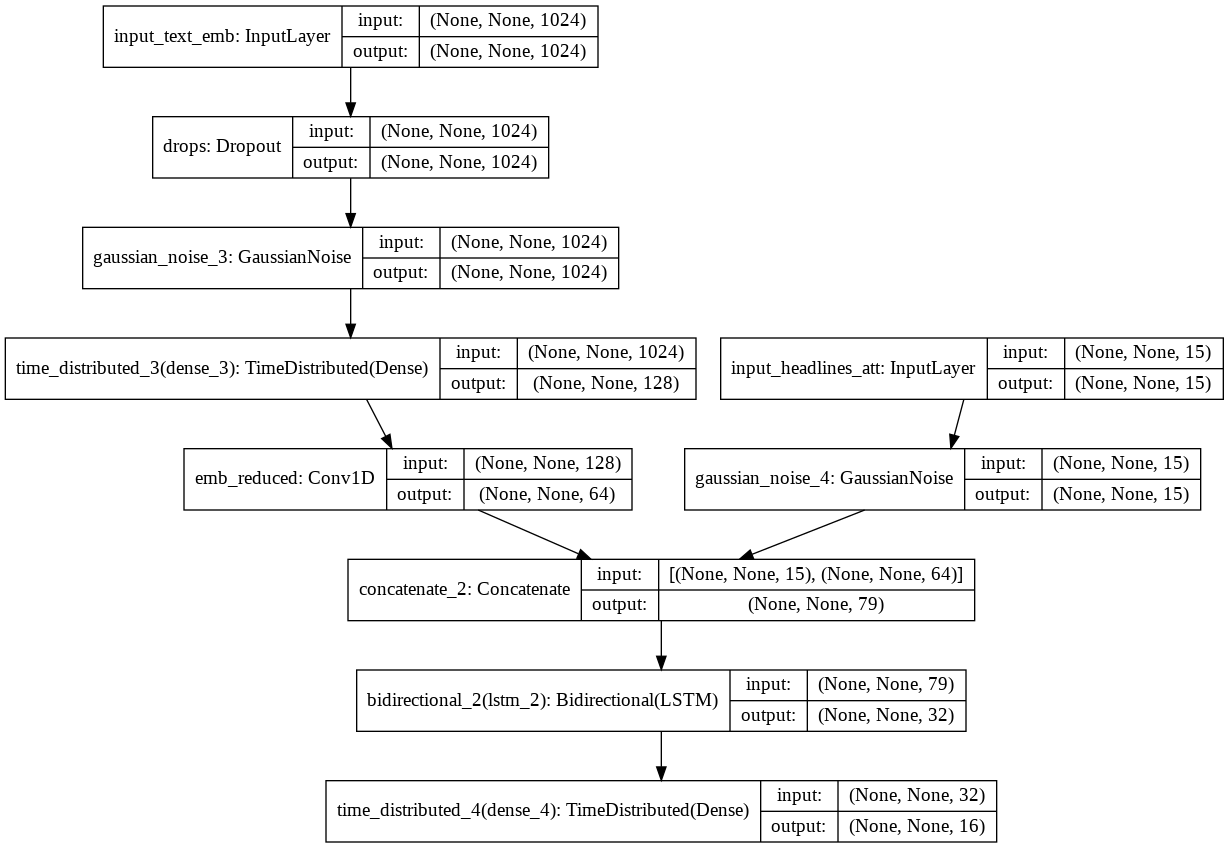

In [0]:
def structure_detection_model_03 (name): 

  EMB =   1024
  FEATURES = len(seq_labels_contract)

  input_text_emb =  Input(shape = [ None, EMB] , dtype='float32', name="input_text_emb")
  input_headlines = Input(shape=  [ None, TOKEN_FEATURES],    dtype='float32', name="input_headlines_att")
  

 
  if True: # 1: input: embeddings
    # reducing embedding dimetionality
    _out = Dropout(0.3, name="drops")(input_text_emb) #small_drops_of_poison
    _out = GaussianNoise(0.01)(_out)  
    _out = TimeDistributed(Dense(FEATURES*8, activation="sigmoid"))(_out)
    _out = Conv1D( filters = FEATURES*4, kernel_size=(3), padding='same', activation='relu', name="emb_reduced" )(_out)
  # --------

  if True: # 2: input: random-forest-predicted headlines met info
    _i2 = GaussianNoise(0.1)(input_headlines)   


  _out = concatenate( [_i2, _out], axis=-1 ) # mixing in the random-forest-predicted headlines
  _out = Bidirectional(LSTM(16, return_sequences=True))(_out)  
  _out = TimeDistributed(Dense(FEATURES, activation="sigmoid"))(_out)
 
  
  model = Model(inputs=[input_text_emb, input_headlines], outputs=_out, name=name)
 
  # model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy', 'categorical_accuracy'])
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy', 'categorical_accuracy'])  
  # model.compile(loss='mse', optimizer='Nadam', metrics=['accuracy', 'categorical_accuracy'])  
  return model
 

model = structure_detection_model_03( structure_detection_model_03.__name__  )
model.summary()
# model.load_weights (path.join(model_checkpoint_path, model.name+".weights"))


plot_model(model, show_shapes=True)


In [0]:

EPOCHS=40
train_generator = make_generator(dataset_manager, dataset_manager.train_indices, 48)
test_generator  = make_generator(dataset_manager, dataset_manager.test_indices, 48)
train_and_evaluate_model(model, generator=train_generator, test_generator=test_generator)

model.name=structure_detection_model_03
outliers_percent=0.05
noisy_samples_amount=0.5
noise_amount=0.05
Epoch 1/40
25/25 [==============================] - 84s 3s/step - loss: 0.0281 - accuracy: 0.7779 - categorical_accuracy: 0.7779 - val_loss: 0.1059 - val_accuracy: 0.5504 - val_categorical_accuracy: 0.5504

Epoch 00001: val_loss improved from inf to 0.10593, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/structure_detection_model_03

Epoch 00001: val_loss improved from inf to 0.10593, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/structure_detection_model_03.weights
Epoch 2/40
25/25 [==============================] - 45s 2s/step - loss: 0.0307 - accuracy: 0.7792 - categorical_accuracy: 0.7792 - val_loss: 0.0940 - val_accuracy: 0.4965 - val_categorical_accuracy: 0.4965

Epoch 00002: val_loss improved from 0.10593 to 0.09399, saving model to /content/drive/My Drive/GazpromOil/trainsets/checkpoints/1_1_19/structure_dete

### ~1??K structure_detection_model_04 (not tested clone)~
 

In [0]:
def structure_detection_model_04 (name): 

  EMB =   1024
  FEATURES = len(seq_labels_contract)

  input_text_emb =  Input(shape = [ None, EMB] , dtype='float32', name="input_text_emb")
  input_headlines = Input(shape=  [ None, TOKEN_FEATURES],    dtype='float32', name="input_headlines_att")
  

 
  if True: # 1: input: embeddings
    # reducing embedding dimetionality
    _out = Dropout(0.3, name="drops")(input_text_emb) #small_drops_of_poison
    _out = GaussianNoise(0.01)(_out)  
    _out = TimeDistributed(Dense(FEATURES*8, activation="sigmoid"))(_out)
    _out = Conv1D( filters = FEATURES*4, kernel_size=(3), padding='same', activation='relu', name="emb_reduced" )(_out)
  # --------

  if True: # 2: input: random-forest-predicted headlines met info
    _i2 = GaussianNoise(0.1)(input_headlines)   


  _out = concatenate( [_i2, _out], axis=-1 ) # mixing in the random-forest-predicted headlines
  _out = Bidirectional(LSTM(16, return_sequences=True))(_out)  
  _out = TimeDistributed(Dense(FEATURES, activation="sigmoid"))(_out)
 
  
  model = Model(inputs=[input_text_emb, input_headlines], outputs=_out, name=name)
 
  # model.compile(loss='binary_crossentropy', optimizer='Nadam', metrics=['accuracy', 'categorical_accuracy'])
  model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy', 'categorical_accuracy'])  
  # model.compile(loss='mse', optimizer='Nadam', metrics=['accuracy', 'categorical_accuracy'])  
  return model
 

model = structure_detection_model_04( structure_detection_model_04.__name__  )
model.summary()
# model.load_weights (path.join(model_checkpoint_path, model.name+".weights"))


plot_model(model, show_shapes=True)


In [0]:

EPOCHS=20
train_generator = make_generator(dataset_manager, dataset_manager.train_indices, 48)
test_generator  = make_generator(dataset_manager, dataset_manager.test_indices, 48)
train_and_evaluate_model(model, generator=train_generator, test_generator=test_generator)

# Evaluate models

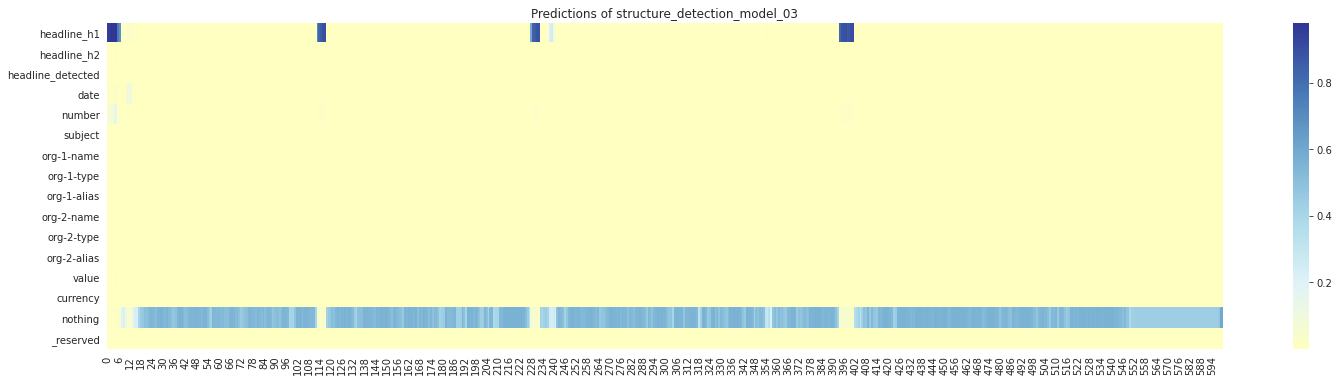

In [27]:
# trying model
 
import numpy as np
V_DOC_INDEX = 120
x, y = make_xy(V_DOC_INDEX)


sm = model.predict([[x[0]], [x[1]]] )[0]


d = load_doc(V_DOC_INDEX) 
df = pd.DataFrame(sm, columns=seq_labels_contract)
plot_emb(df, title = f'Predictions of {model.name}')
# df['nothing']=0.1


In [0]:
HTML(render_doc (d, df))